In [1]:
import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

2025-08-03 11:06:27.147815: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 11:06:27.476113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 11:06:27.478154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-03 11:06:28.555562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Example: Challenger Space Shuttle Disaster <span id="challenger"/>

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):






import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
filename = wget.download(url)
filename

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


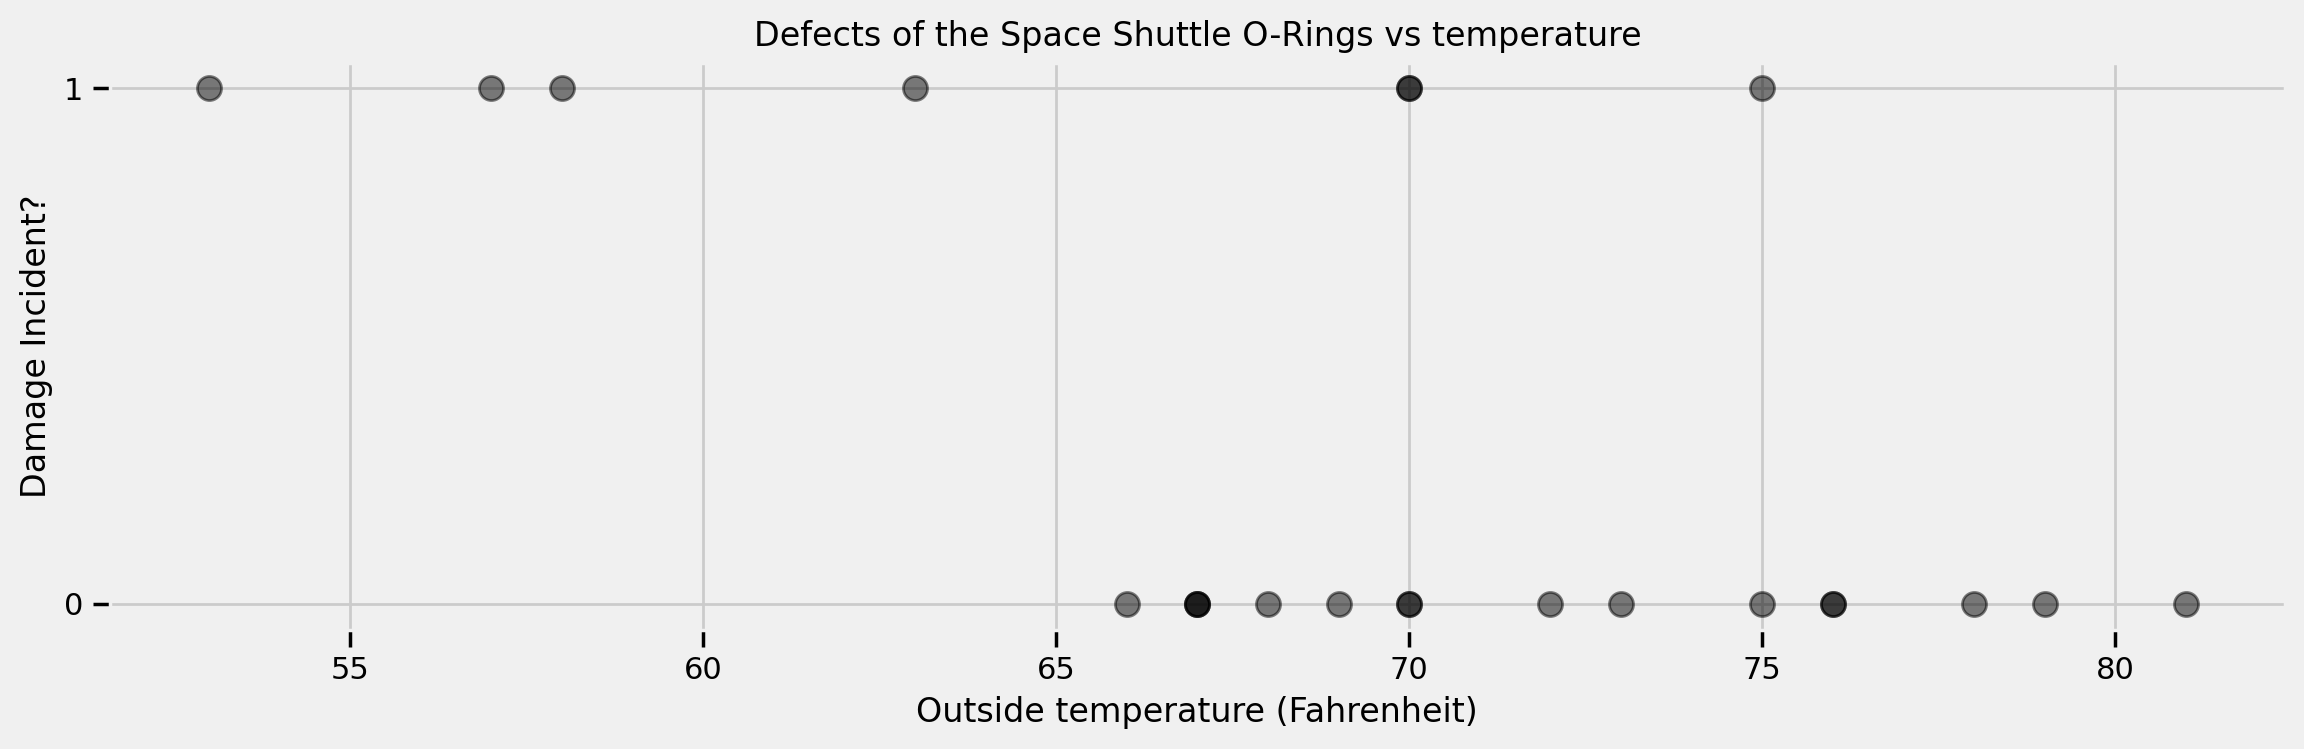

In [5]:
plt.figure(figsize(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data_ = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data_ = challenger_data_[~np.isnan(challenger_data_[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data_)

plt.scatter(challenger_data_[:, 0], challenger_data_[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");


It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it $p(t)$, that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

In [9]:

temperature_ = challenger_data_[:, 0]
D_ = challenger_data_[:, 1]                # defect or not?

In [13]:
class LogisticMLE:
    """
    Logistic Regression using Maximum Likelihood Estimation with TensorFlow.
    
    Fits logistic regression using gradient-based optimization to maximize
    the likelihood function.
    """
    
    def __init__(self, trainable: bool = True):
        """
        Initialize the logistic regression model.
        
        Args:
            trainable: Whether parameters should be trainable (default: True)
        """
        # Initialize parameters as tf.Variables
        self.alpha = tf.Variable(0.0, dtype=tf.float32, trainable=trainable, name='alpha')
        self.beta = tf.Variable(0.0, dtype=tf.float32, trainable=trainable, name='beta')
        
        # Store data after fitting
        self.temperature = None
        self.failure = None
        self.is_fitted = False
        
    def set_parameters(self, alpha: float, beta: float):
        """
        Set the model parameters to specific values.
        
        Args:
            alpha: Intercept parameter
            beta: Slope parameter
        """
        self.alpha.assign(tf.constant(alpha, dtype=tf.float32))
        self.beta.assign(tf.constant(beta, dtype=tf.float32))
        
    def logistic_probability(self, temperature: tf.Tensor) -> tf.Tensor:
        """
        Compute logistic probability: P(failure) = 1 / (1 + exp(-(beta * temperature + alpha)))
        
        Args:
            temperature: Input temperature values
            
        Returns:
            Probability of failure for each temperature value
        """
        logit = self.beta * temperature + self.alpha
        return 1.0 / (1.0 + tf.exp(-logit))
    
    def negative_log_likelihood(self, temperature: tf.Tensor, failure: tf.Tensor) -> tf.Tensor:
        """
        Compute negative log-likelihood for logistic regression.
        
        Args:
            temperature: Input temperature values
            failure: Binary failure outcomes (0 or 1)
            
        Returns:
            Negative log-likelihood value
        """
        probs = self.logistic_probability(temperature)
        
        # Bernoulli log-likelihood: sum(y * log(p) + (1-y) * log(1-p))
        log_likelihood = tf.reduce_sum(
            failure * tf.math.log(probs + 1e-8) + 
            (1.0 - failure) * tf.math.log(1.0 - probs + 1e-8)
        )
        
        return -log_likelihood  # Return negative for minimization
    
    def fit(self, temperature: np.ndarray, failure: np.ndarray, 
            learning_rate: float = 0.01, epochs: int = 1000, 
            verbose: bool = True) -> dict:
        """
        Fit the logistic regression model using gradient descent.
        
        Args:
            temperature: Input temperature values
            failure: Binary failure outcomes (0 or 1)
            learning_rate: Learning rate for gradient descent
            epochs: Number of training epochs
            verbose: Whether to print training progress
            
        Returns:
            Dictionary containing training history
        """
        # Convert inputs to TensorFlow tensors
        self.temperature = tf.constant(temperature, dtype=tf.float32)
        self.failure = tf.constant(failure, dtype=tf.float32)
        
        # Initialize optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        # Training history
        history = {
            'loss': [],
            'alpha': [],
            'beta': []
        }
        
        # Training loop
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                loss = self.negative_log_likelihood(self.temperature, self.failure)
            
            # Compute gradients
            gradients = tape.gradient(loss, [self.alpha, self.beta])
            
            # Apply gradients
            optimizer.apply_gradients(zip(gradients, [self.alpha, self.beta]))
            
            # Store history
            history['loss'].append(float(loss))
            history['alpha'].append(float(self.alpha))
            history['beta'].append(float(self.beta))
            
            # Print progress
            if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch}: Loss = {float(loss):.4f}, Alpha = {float(self.alpha):.4f}, Beta = {float(self.beta):.4f}")
        
        self.is_fitted = True
        return history
    
    def predict_proba(self, temperature: np.ndarray) -> np.ndarray:
        """
        Predict failure probabilities for given temperatures.
        
        Args:
            temperature: Input temperature values
            
        Returns:
            Predicted failure probabilities
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        temp_tensor = tf.constant(temperature, dtype=tf.float32)
        probs = self.logistic_probability(temp_tensor)
        return probs.numpy()
    
    def predict(self, temperature: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Predict binary failure outcomes for given temperatures.
        
        Args:
            temperature: Input temperature values
            threshold: Probability threshold for classification
            
        Returns:
            Predicted binary outcomes
        """
        probs = self.predict_proba(temperature)
        return (probs >= threshold).astype(int)

In [14]:
challenger_mle = LogisticMLE()

# Training

In [18]:
challenger_mle.fit(temperature = temperature_, failure=D_, learning_rate = 0.01, epochs=5000)

Epoch 0: Loss = 11.4497, Alpha = 5.1558, Beta = -0.0977
Epoch 100: Loss = 11.3444, Alpha = 5.5048, Beta = -0.0929
Epoch 200: Loss = 11.1997, Alpha = 6.0256, Beta = -0.1005
Epoch 300: Loss = 11.0508, Alpha = 6.6087, Beta = -0.1090
Epoch 400: Loss = 10.9117, Alpha = 7.2097, Beta = -0.1177
Epoch 500: Loss = 10.7874, Alpha = 7.8068, Beta = -0.1264
Epoch 600: Loss = 10.6791, Alpha = 8.3882, Beta = -0.1349
Epoch 700: Loss = 10.5862, Alpha = 8.9473, Beta = -0.1431
Epoch 800: Loss = 10.5075, Alpha = 9.4805, Beta = -0.1509
Epoch 900: Loss = 10.4415, Alpha = 9.9857, Beta = -0.1582
Epoch 1000: Loss = 10.3864, Alpha = 10.4621, Beta = -0.1652
Epoch 1100: Loss = 10.3408, Alpha = 10.9095, Beta = -0.1717
Epoch 1200: Loss = 10.3033, Alpha = 11.3279, Beta = -0.1778
Epoch 1300: Loss = 10.2727, Alpha = 11.7178, Beta = -0.1835
Epoch 1400: Loss = 10.2477, Alpha = 12.0799, Beta = -0.1888
Epoch 1500: Loss = 10.2276, Alpha = 12.4148, Beta = -0.1937
Epoch 1600: Loss = 10.2115, Alpha = 12.7234, Beta = -0.1982
Ep

{'loss': [11.449747085571289,
  12.342188835144043,
  11.496734619140625,
  11.714873313903809,
  11.977425575256348,
  11.708368301391602,
  11.459911346435547,
  11.496246337890625,
  11.658834457397461,
  11.70943546295166,
  11.611822128295898,
  11.4810152053833,
  11.440239906311035,
  11.50766658782959,
  11.5797119140625,
  11.564645767211914,
  11.488664627075195,
  11.436990737915039,
  11.450431823730469,
  11.495552062988281,
  11.515596389770508,
  11.490806579589844,
  11.448736190795898,
  11.430164337158203,
  11.447120666503906,
  11.471885681152344,
  11.471820831298828,
  11.447832107543945,
  11.427643775939941,
  11.429655075073242,
  11.444618225097656,
  11.451196670532227,
  11.44118595123291,
  11.425972938537598,
  11.421199798583984,
  11.428536415100098,
  11.435137748718262,
  11.430996894836426,
  11.420906066894531,
  11.416139602661133,
  11.419541358947754,
  11.423635482788086,
  11.421512603759766,
  11.41503620147705,
  11.4111909866333,
  11.4126539

# Simulation

In [ ]:
challenger_mle.trainable = False

In [29]:
challenger_mle.alpha

<tf.Variable 'alpha:0' shape=() dtype=float32, numpy=15.042621>

In [28]:
"""
Simple Data Generation Example with LogisticMLE

Direct approach to generate data with specific parameters.
"""
import numpy as np

# Step 1: Create the model and set parameters
model = LogisticMLE(trainable=False)  # trainable=False since we're not fitting
model.set_parameters(alpha=-10.0, beta=0.3)
model.is_fitted = True

# Step 2: Generate temperature data
n_samples = 1000
temperature = np.random.uniform(0, 180, n_samples)  # Random temperatures between 20-80°C

# Step 3: Generate failure probabilities using the model
probabilities = model.predict_proba(temperature)

# Step 4: Generate binary failure outcomes
failure = np.random.binomial(1, probabilities)

# Step 5: Examine the results
print(f"Generated {n_samples} samples")
print(f"Parameters: α = -10.0, β = 0.3")
print(f"Temperature range: [{temperature.min():.1f}, {temperature.max():.1f}]")
print(f"Failure rate: {np.mean(failure):.3f}")
print(f"Mean failure probability: {np.mean(probabilities):.3f}")

# Show first few examples
print(f"\nFirst 20 examples:")
for i in range(20):
    print(f"Temp: {temperature[i]:.1f}°C, Prob: {probabilities[i]:.3f}, Failure: {failure[i]}")

# Your data is now ready to use:
print(f"\nYour generated data:")
print(f"temperature.shape: {temperature.shape}")
print(f"failure.shape: {failure.shape}")
print(f"Data types: temperature={temperature.dtype}, failure={failure.dtype}") 

Generated 1000 samples
Parameters: α = -10.0, β = 0.3
Temperature range: [0.3, 179.9]
Failure rate: 0.815
Mean failure probability: 0.813

First 20 examples:
Temp: 161.4°C, Prob: 1.000, Failure: 1
Temp: 20.7°C, Prob: 0.022, Failure: 0
Temp: 26.7°C, Prob: 0.120, Failure: 0
Temp: 91.8°C, Prob: 1.000, Failure: 1
Temp: 59.2°C, Prob: 1.000, Failure: 1
Temp: 50.2°C, Prob: 0.994, Failure: 1
Temp: 1.7°C, Prob: 0.000, Failure: 0
Temp: 78.1°C, Prob: 1.000, Failure: 1
Temp: 50.8°C, Prob: 0.995, Failure: 1
Temp: 57.0°C, Prob: 0.999, Failure: 1
Temp: 114.1°C, Prob: 1.000, Failure: 1
Temp: 56.6°C, Prob: 0.999, Failure: 1
Temp: 13.9°C, Prob: 0.003, Failure: 0
Temp: 125.8°C, Prob: 1.000, Failure: 1
Temp: 36.3°C, Prob: 0.707, Failure: 1
Temp: 36.1°C, Prob: 0.695, Failure: 1
Temp: 77.1°C, Prob: 1.000, Failure: 1
Temp: 87.8°C, Prob: 1.000, Failure: 1
Temp: 121.6°C, Prob: 1.000, Failure: 1
Temp: 51.9°C, Prob: 0.996, Failure: 1

Your generated data:
temperature.shape: (1000,)
failure.shape: (1000,)
Data ty

In [27]:
failure

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,

In [ ]:
class DSCLayer(tf.keras.Layer):
    ...
    LogLikelihood
    
    def call(input_var):
        define f...
            parameters @ input_variable + noise
        return f(input_var)
    
dsc = DSCLayer(...)
input_variables = ...
output = dsc(input_variables)

class RandomModel(tf.keras.Model):
    __init__
    self.dsc = DSCLayer()
    self.drr = DRRLayer()
    
    def call(input):
        output1 = self.dsc(input) + self.drr(input)
        ouptut2 = self.dsc(input) * self.drr(input)
        return output1 - output2
    
    fit